$\large{\textbf{Reconstruction of DOSY NMR signals}}$ 

$\textbf{Adnan}$ $\textbf{ZEDDOUN}$ 

$\textbf{Partie 2 - Generation of synthetic data}$ 

In [73]:
## TP 2 LSD Partie 1

import numpy  as np
import numpy.linalg as alg
import matplotlib.pyplot as plt
from scipy.linalg import circulant

##Partie 2 - Generation of synthetic data

x = open("C:/Users/Adnan/Videos/TP2 LSD/x.txt")
x = x.read()
x = x.split("\n")

N = 200
Tmin = 1
Tmax = 1000

vec = np.zeros(N)
for i in range(N):
    vec[i] = float(x[i])

T = np.zeros(N)
for i in range(1,N+1):
    T[i-1] = Tmin*np.exp(-(i-1)*np.log(Tmin/Tmax)/(N-1))

In [3]:
M = 50
tmin = 0
tmax = 1.5
tvec = np.zeros(M)

for i in range(1,M+1):
    tvec[i-1] = tmin + (i-1)/(M-1)*(tmax-tmin)

In [4]:
K = np.zeros((M,N))
for i in range(M):
    for j in range(N):
        K[i,j] = np.exp(-T[j]*tvec[i])      

In [5]:
z = np.dot(K,vec)
z1 = 0.01*z[0]
w = np.random.normal(0,z1,M)
y = z + w

Text(0.5, 1.0, 'Signaux réels et bruité en fonction de t')

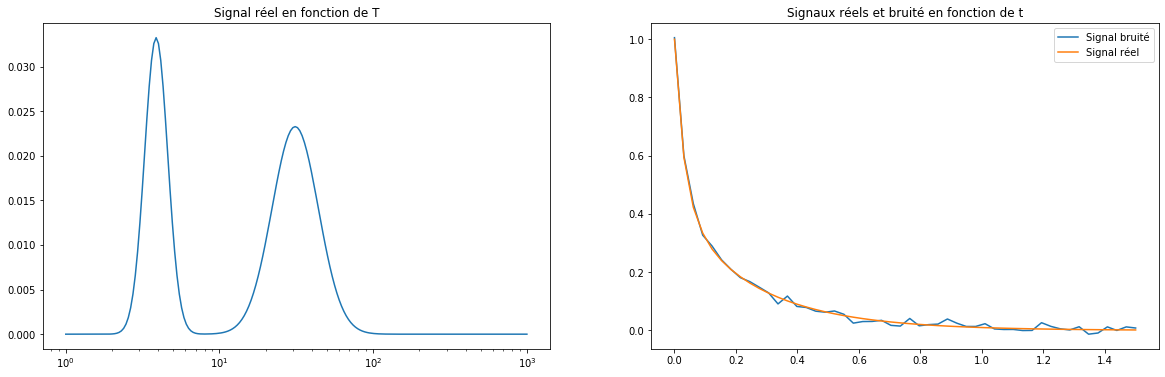

In [71]:
fig,a = plt.subplots(1,2, figsize=(20,6))
a[0].plot(T,vec)
a[0].set_xscale('log')
a[0].set_title('Signal réel en fonction de T')

a[1].plot(tvec,y,label='Signal bruité')
a[1].plot(tvec,z, label='Signal réel')
a[1].legend()
a[1].set_title('Signaux réels et bruité en fonction de t')

$\textbf{Partie 3 - Comparison of regularization strategies}$ 



$\text{Smoothness prior}$ :
Le problème d'optimisation est 
$$\underset{x}{min}  f(x) = \frac{1}{2}\| Kx-y\|^{2} + \frac{\beta}{2}\| Dx\|^{2}$$

$\text{Q1}$) Le fonction $f$ est propre, continue et coercive. De plus $f$ est strictement convexe et $R^{N}$ est convexe. Ainsi $f$ possède un unique minimum.

$\text{Q2}$)Pour résoudre ce problème d'optimisation, il suffit de trouver $x$ qui annule le gradient.
$$\nabla f(x) = K^{T}Kx - K^{T}y + \beta D^{T}Dx $$
On a alors $\hat{x} = (K^{T}K + \beta D^{T}D)^{-1}K^{T}y $

$\text{Q3}$) Implémentons le signal restoré $\hat{x}$

In [89]:
c = np.zeros(N)
c[0] = 1
c[1] = -1
D = circulant(c) #matrice D

def xhat1(beta):
    res = np.linalg.solve(np.dot(np.transpose(K),K) + beta*np.dot(np.transpose(D),D),np.dot(np.transpose(K),y))
    return res

In [8]:
def erreur_quadratique_noramlisée(x, x_hat):
    return np.linalg.norm(x-x_hat)**2/np.linalg.norm(x)**2

In [8]:
##Erreur quadratique normalisée pour bêta = 0.1,0.5,1,10,100,1000

err1 = erreur_quadratique_noramlisée(vec, xhat1(0.1))
err2 = erreur_quadratique_noramlisée(vec, xhat1(0.5))
err3 = erreur_quadratique_noramlisée(vec, xhat1(1))
err4 = erreur_quadratique_noramlisée(vec, xhat1(10))
err5 = erreur_quadratique_noramlisée(vec, xhat1(20))
err6 = erreur_quadratique_noramlisée(vec, xhat1(100))
err7 = erreur_quadratique_noramlisée(vec, xhat1(1000))

print(err1,err2,err3,err4,err5,err6,err7)

1.992714708238861 0.5455595820100917 0.20305834829386596 0.3416368658642924 0.38864491266253426 0.4541502813959382 0.5598896088081157


On choisit $\beta = 0.5$

(0.0, 1.0, 0.0, 1.0)

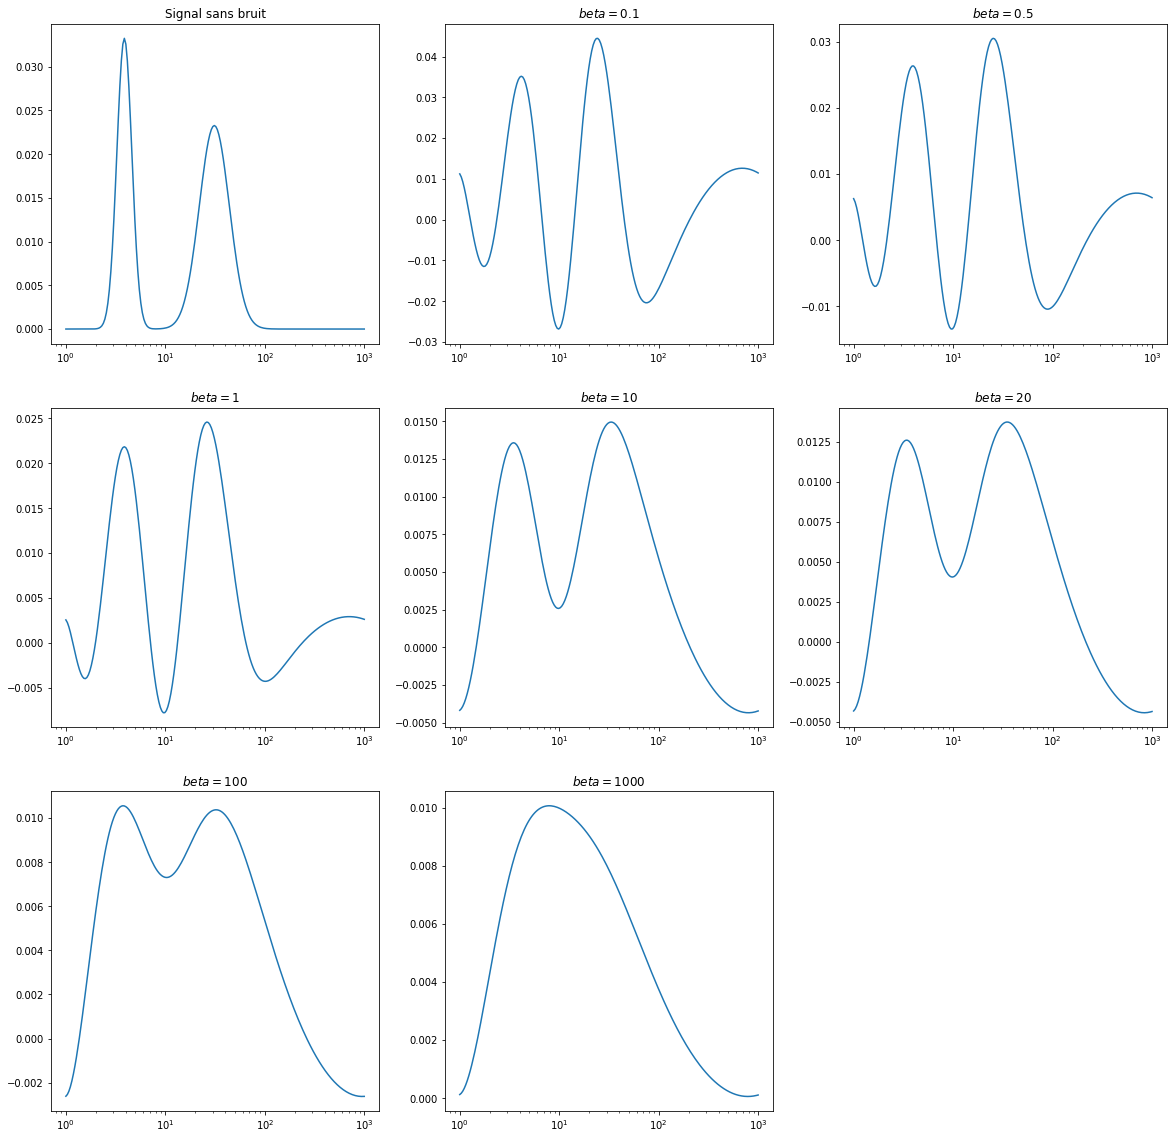

In [9]:
fig1 ,a1 = plt.subplots(3,3,figsize=(20,20))

a1[0,0].set_title('Signal sans bruit')
a1[0,0].semilogx(T,vec)

a1[0,1].set_title('$beta=0.1$')
a1[0,1].semilogx(T,xhat1(0.1))

a1[0,2].set_title('$beta=0.5$')
a1[0,2].semilogx(T,xhat1(0.5))

a1[1,0].set_title('$beta=1$')
a1[1,0].semilogx(T,xhat1(1))

a1[1,1].set_title('$beta=10$')
a1[1,1].semilogx(T,xhat1(10))

a1[1,2].set_title('$beta=20$')
a1[1,2].semilogx(T,xhat1(20))

a1[2,0].set_title('$beta=100$')
a1[2,0].semilogx(T,xhat1(100))

a1[2,1].set_title('$beta=1000$')
a1[2,1].semilogx(T,xhat1(1000))

a1[2,2].axis('off')



$\text{Smoothness prior + constraints}$ :
Le problème d'optimisation est 
$$\underset{x}{min}  f(x) = \frac{1}{2}\| Kx-y\|^{2} + \frac{\beta}{2}\| Dx\|^{2} + \iota_{[x1,x2]}(x)$$

$\text{Q1}$) Le fonction $f$ est propre, continue et strictement convexe. Ainsi $f$ possède un minimum et il est unique.

$\text{Q2}$) Pour résoudre ce problème d'optimisation, on utilise l'algorithme de projection.
On note $f_{1}(x) = \frac{1}{2}\| Kx-y\|^{2} + \frac{\beta}{2}\| Dx\|^{2}$
$$\|\nabla f_{1}(x)-\nabla f_{1}(y)\| = \|(K^{T}K + \beta D^{T}D)(x-y)\| \leq max(Sp(K^{T}K + \beta D^{T}D))\|x-y\|$$
On pose $\alpha = max(Sp(K^{T}K + \beta D^{T}D))$. Ainsi, $\nabla f_{1}$ est $\alpha$-lipschitzien


$\text{Q3}$) Implémentons le signal restoré $\hat{x}$

In [87]:
def grad1(x,beta):
    res = np.dot(np.dot(np.transpose(K),K),x) - np.dot(np.transpose(K),y) + beta*np.dot(np.dot(np.transpose(D),D),x)
    return res

x0 = np.zeros(len(vec))
epsilon = 10**-6

def projected_grad(beta,x0,epsilon):
    vpmax1 = np.max(alg.eigvals(np.dot(np.transpose(K),K) + beta*np.dot(np.transpose(D),D)))
    gamma1 = 1.98/vpmax1
    delta1 = 2-gamma1*vpmax1/2
    lambda1 = delta1/2
    itmax = 50000
    it = 0
    xn = x0
    err = 1
    while it<=itmax and err>epsilon:
        f = xn - gamma1*grad1(xn,beta)
        xnew = xn + lambda1*(np.clip(f,min(vec),max(vec))-xn)
        it = it + 1
        err = np.linalg.norm(xnew - xn,1)/np.linalg.norm(xn,1)
        xn = xnew
    return xn

In [11]:
##Erreur quadratique normalisée pour bêta = 0.1,0.5,1,10,100,1000

err1 = erreur_quadratique_noramlisée(vec, projected_grad(0.1,x0,epsilon))
err2 = erreur_quadratique_noramlisée(vec, projected_grad(0.5,x0,epsilon))
err3 = erreur_quadratique_noramlisée(vec, projected_grad(1,x0,epsilon))
err4 = erreur_quadratique_noramlisée(vec, projected_grad(10,x0,epsilon))
err5 = erreur_quadratique_noramlisée(vec, projected_grad(20,x0,epsilon))
err6 = erreur_quadratique_noramlisée(vec, projected_grad(100,x0,epsilon))
err7 = erreur_quadratique_noramlisée(vec, projected_grad(1000,x0,epsilon))

print(err1,err2,err3,err4,err5,err6,err7)

C:\Users\Adnan\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


0.04773901778322603 0.033930084003816474 0.04567858808210784 0.17758525749776313 0.2533366109516797 0.43420884024500894 0.5601636755571883


On choisit $\beta = 0.5$

C:\Users\Adnan\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


(0.0, 1.0, 0.0, 1.0)

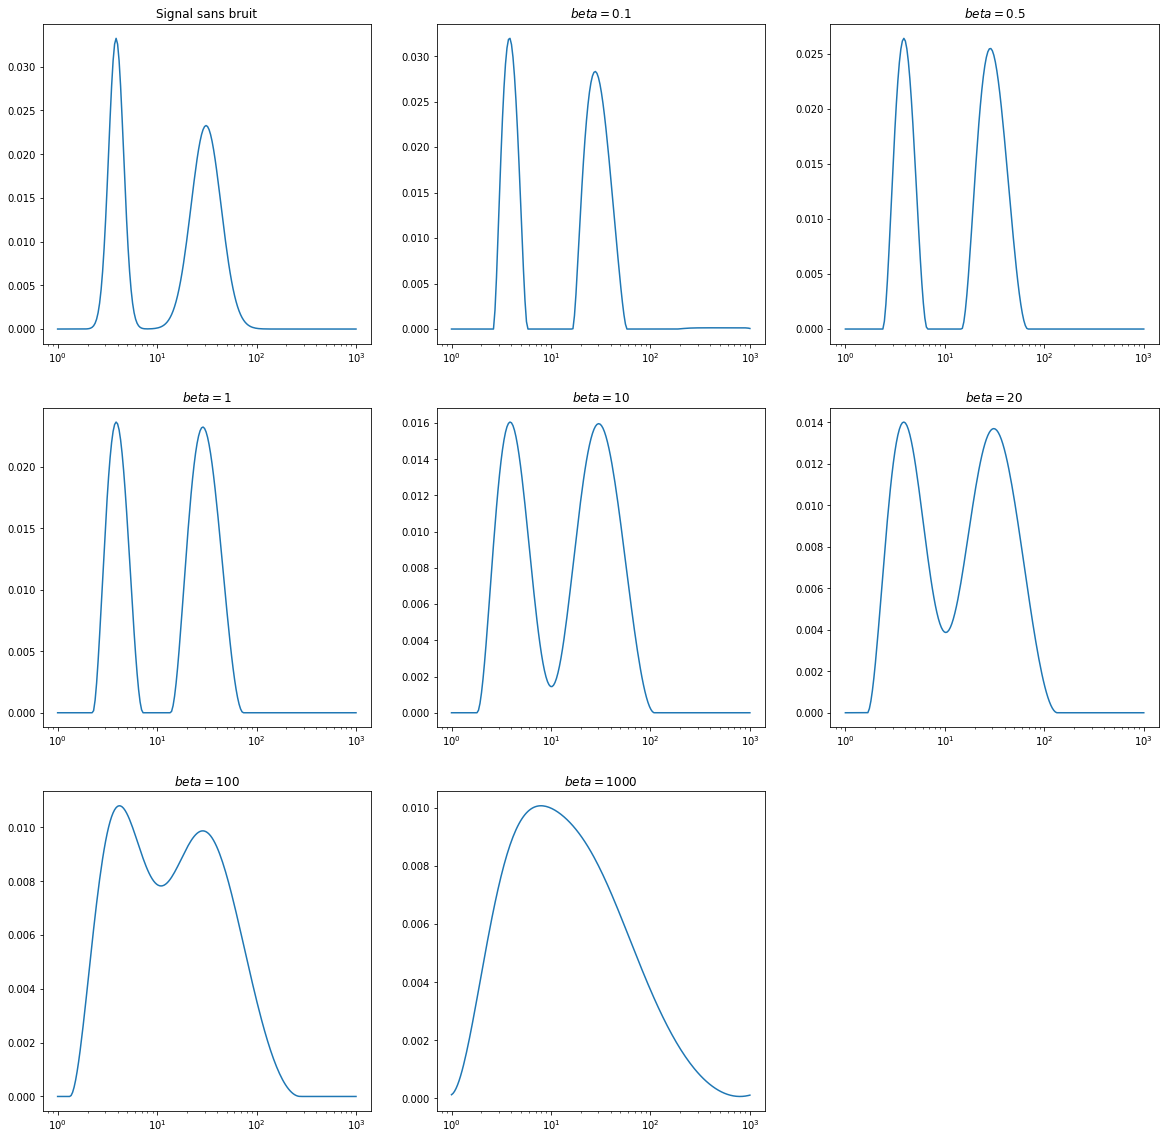

In [12]:
fig2 ,a2 = plt.subplots(3,3,figsize=(20,20))

a2[0,0].set_title('Signal sans bruit')
a2[0,0].semilogx(T,vec)

a2[0,1].set_title('$beta=0.1$')
a2[0,1].semilogx(T,projected_grad(0.1,x0,epsilon))

a2[0,2].set_title('$beta=0.5$')
a2[0,2].semilogx(T,projected_grad(0.5,x0,epsilon))

a2[1,0].set_title('$beta=1$')
a2[1,0].semilogx(T,projected_grad(1,x0,epsilon))

a2[1,1].set_title('$beta=10$')
a2[1,1].semilogx(T,projected_grad(10,x0,epsilon))

a2[1,2].set_title('$beta=20$')
a2[1,2].semilogx(T,projected_grad(20,x0,epsilon))

a2[2,0].set_title('$beta=100$')
a2[2,0].semilogx(T,projected_grad(100,x0,epsilon))

a2[2,1].set_title('$beta=1000$')
a2[2,1].semilogx(T,projected_grad(1000,x0,epsilon))

a2[2,2].axis('off')


$\text{Sparsity prior}$ :
Le problème d'optimisation est 
$$\underset{x}{min}  f(x) = \frac{1}{2}\| Kx-y\|^{2} + \beta\| x\|_{1}$$

$\text{Q1}$) Le fonction $f$ est propre, continue et strictement convexe. Ainsi $f$ possède un minimum et il est unique.

$\text{Q2}$) Pour résoudre ce problème d'optimisation, on utilise l'algorithme de projection.
On note $f_{2}(x) = \frac{1}{2}\| Kx-y\|^{2}$
$$\|\nabla f_{2}(x)-\nabla f_{2}(y)\| = \|K^{T}K(x-y)\| \leq max(Sp(K^{T}K))\|x-y\|$$
On pose $\mu = max(Sp(K^{T}K))$. Ainsi, $\nabla f_{2}$ est $\mu$-lipschitzien



$\text{Q3}$) Implémentons le signal restoré $\hat{x}$

In [85]:
def grad2(x):
    res = np.dot(np.dot(np.transpose(K),K),x) - np.dot(np.transpose(K),y) 
    return res

x0 = np.zeros(len(vec))
epsilon = 10**-6

def FB_alg(beta,x0,epsilon):
    vpmax2 = np.max(alg.eigvals(np.dot(np.transpose(K),K)))
    gamma2 = 1.98/vpmax2
    delta2 = 2-gamma2*vpmax2/2
    lambda2 = delta2/2
    itmax = 50000
    err = 1
    it = 0
    xn = x0
    while it<=itmax and err>epsilon:
        f = xn - gamma2*grad2(xn)
        xnew = xn + lambda2*(np.sign(f)*np.clip(np.abs(f)-gamma2*beta,0,np.inf)-xn)
        it = it + 1
        err = np.linalg.norm(xnew - xn,1)/np.linalg.norm(xn,1)
        xn = xnew
    return xn

In [14]:
##Erreur quadratique normalisée pour bêta = 0.01,0.001,0.0005,0.0001

err1 = erreur_quadratique_noramlisée(vec, FB_alg(0.01,x0,epsilon))
err2 = erreur_quadratique_noramlisée(vec, FB_alg(0.001,x0,epsilon))
err3 = erreur_quadratique_noramlisée(vec, FB_alg(0.0005,x0,epsilon))
err4 = erreur_quadratique_noramlisée(vec, FB_alg(0.0001,x0,epsilon))

print(err1,err2,err3,err4)

C:\Users\Adnan\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


0.07632642718260152 0.06400486205469465 0.06965792611953701 0.19454387458313577


On choisit $\beta = 0.001$

C:\Users\Adnan\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Adnan\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 1.0, 0.0, 1.0)

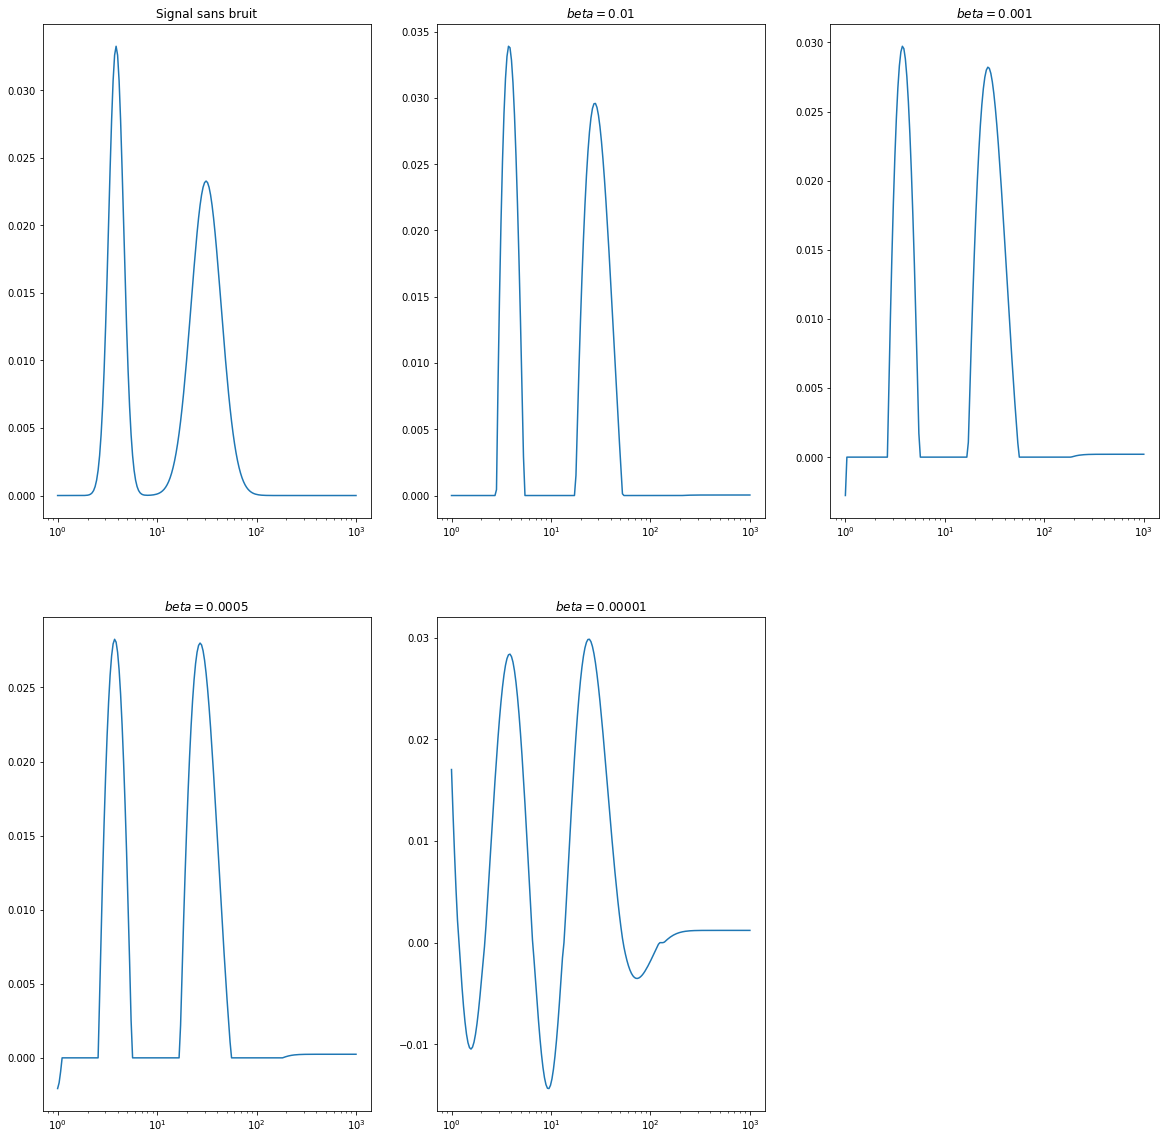

In [15]:
fig3 ,a3 = plt.subplots(2,3,figsize=(20,20))

a3[0,0].set_title('Signal sans bruit')
a3[0,0].semilogx(T,vec)

a3[0,1].set_title('$beta=0.01$')
a3[0,1].semilogx(T,FB_alg(0.01,x0,epsilon))

a3[0,2].set_title('$beta=0.001$')
a3[0,2].semilogx(T,FB_alg(0.001,x0,epsilon))

a3[1,0].set_title('$beta=0.0005$')
a3[1,0].semilogx(T,FB_alg(0.0005,x0,epsilon))

a3[1,1].set_title('$beta=0.00001$')
a3[1,1].semilogx(T,FB_alg(0.00001,x0,epsilon))

a3[1,2].axis('off')


$\textbf{Partie 4 - Maximum entropy regularization}$ 

In [6]:
from scipy.special import lambertw
import numpy  as np
import numpy.linalg as alg
import matplotlib.pyplot as plt

Q1) Etudions la convexité de la fonction $\phi(u) = ulog(u)$

Si $u>0$, $\phi^{''}(u) = \frac{1}{u} >0$. Ainsi $\phi$ est strictement convexe sur $R_{+}^{*}$. Le prolongement de $\phi$ sur $R_{-}$ défini par l'énoncé est aussi strictement convexe ainsi la fonction $ent$ est strcitement convexe en tant que somme de fonctions strictement convexes.

$phi$ est clairement propre (on prend un $u>0$) donc $ent$ aussi.

La fonction $\phi$ est continue sur $R_{+}^{*}$ et admet une limite finie en $0^{+}$ qui vaut $0$. $\phi$ est donc prolongeable par continuité en $0$. Ainsi l'épigraphe de $\phi$ est fermé donc $\phi$ est semi-continue inférieure. Par somme, on en déduit que $ent$ est aussi semi-continue inférieure. 

$\phi^{'}$ n'est pas prolongeable par continuité en $0$ car sa limite en  $0^{+}$ qui vaut $\infty$. Ainsi $\phi$ n'est pas différentiable sur son domaine de définition. On en déduit que $ent$ n'est pas différentiable.

Q2) La fonction $f(x) = \frac{1}{2}\| Kx-y\|^{2} +\beta ent(x)$ est strictement convexe, semi-continue inférieure, propre donc elle admet un minimum et il est unique. 

Q3) La fonction $ent$ est sépérable, pour calculer son opérateur proximale il suffit de calculer le proximale de $\beta \phi$. Pour cela calculons $\underset{u}{min} f(u) = \frac{1}{2}\|u-x\|^{2} +\beta \phi(u)$. 
La dérivée de $f$ s'annule lorsque $\beta log(u) + u = x - \beta$. Après calculs, comme $f$ admet un unique minimum, on sait qu'il est atteint en $u=\beta W(e^{\frac{x}{\beta}-1-log(\beta)})$ où $W$ est la W-fonction de Lambert.
On en déduit que $prox_{\beta ent}(x) = (\beta W(e^{\frac{x^{(i)}}{\beta}-1-log(\beta)}))_{1 \leq i \leq N}$
où $x = (x^{(1)},...,x^{(N)})$.

D'autre part, l'opérateur proximale de  $h(x) = \frac{1}{2}\| Kx-y\|^{2}$ est obtenu en trouvant le minimiseur de :
$$\underset{u}{min} = \frac{1}{2}\| Ku-y\|^{2} + \frac{1}{2}\| u-z\|^{2}$$. Il s'agit de $u=(K^{T}K + I_{N})^{-1}(z+K^{T}y)$

In [69]:
##Algorithme de Douglas Rachford

x0 = np.zeros(len(vec))
epsilon = 10**-6

def DR_alg(beta,gamma,x0,epsilon):
    prox_ent = lambda x: gamma*beta*lambertw(np.exp((x/(beta*gamma)-1-np.log(beta*gamma))))
    prox_f = lambda x: alg.inv(gamma*K.T.dot(K)+np.eye(len(K.T))).dot(gamma*K.T.dot(y)+x)
    itmax = 10000
    err = 1
    it = 0
    xn = x0
    while it<=itmax and err>epsilon:
        yn = prox_ent(xn)
        zn = prox_f(2*yn-xn)
        xnew = xn + 1.98*(zn-yn)
        it = it + 1
        err = np.linalg.norm(xnew - xn,1)/np.linalg.norm(xn,1)
        xn = xnew
    return xn

In [36]:
##Erreur quadratique normalisée pour bêta = 0.01

test = DR_alg(0.01,0.01,x0,epsilon)
errtest = erreur_quadratique_noramlisée(vec, test)

print(errtest)

C:\Users\Adnan\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


0.5804176861742645


In [54]:
##Algorithme de forward-backward version "entropy"

def grad2(x):
    res = np.dot(np.dot(np.transpose(K),K),x) - np.dot(np.transpose(K),y) 
    return res

x0 = np.zeros(len(vec))
epsilon = 10**-6

def FBbis_alg(beta,x0,epsilon):
    vpmax2 = np.max(alg.eigvals(np.dot(np.transpose(K),K)))
    gamma2 = 1.98/vpmax2
    delta2 = 2-gamma2*vpmax2/2
    lambda2 = delta2/2
    itmax = 10000
    err = 1
    it = 0
    xn = x0
    prox_ent = lambda x: gamma2*beta*lambertw(np.exp((x/(beta*gamma2)-1-np.log(beta*gamma2))))
    while it<=itmax and err>epsilon:
        yn = xn - gamma2*grad2(xn)
        xnew = xn + lambda2*(prox_ent(yn)-xn)
        it = it + 1
        err = np.linalg.norm(xnew - xn,1)/np.linalg.norm(xn,1)
        xn = xnew
    return xn


In [45]:
##Erreur quadratique normalisée pour bêta = 0.01

test = FBbis_alg(0.01,x0,epsilon)
errtest = erreur_quadratique_noramlisée(vec, test)

print(errtest)

C:\Users\Adnan\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


0.5822327185923148


On constate que les deux algorithmes ont les mêmes performances à savoir une erreur quadratique normalisée de 0.58 environ pour $\beta = 10^{-2}$

In [70]:
##Erreur quadratique normalisée pour bêta = 0.0001

test = DR_alg(0.0001,1,x0,epsilon)
errtest = erreur_quadratique_noramlisée(vec, test)

print(errtest)

C:\Users\Adnan\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


0.15655813314754286


Le $\beta$ optimal pour le cahier des charges Maximum entropy regularization avec l'algorithme de Douglas-Rachford est $\beta=10^{-4}, \gamma=1, \lambda=1.98$ 

C:\Users\Adnan\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


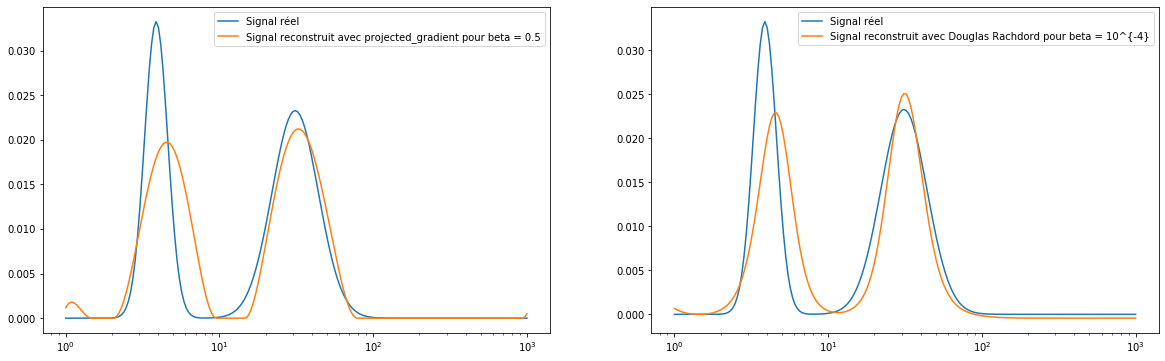

In [91]:
fig,a = plt.subplots(1,2, figsize=(20,6))
a[0].plot(T,vec,label='Signal réel')
a[0].plot(T,projected_grad(0.5,x0,epsilon),label='Signal reconstruit avec projected_gradient pour beta = 0.5') 
a[0].set_xscale('log')
a[0].legend()


a[1].plot(T,vec,label='Signal réel')
a[1].plot(T,test, label='Signal reconstruit avec Douglas Rachdord pour beta = 10^{-4}')
a[1].set_xscale('log')
a[1].legend()


$\textbf{Commentaires :
L'erreur quadratique normalisée pour l'algorithme "projected_gradient" avec le cahier des charges Smoothness prior + constraints pour $\beta = 0.5$ est de 0.03 alors que pour l'algorithme de Douglas-Rachdord avec le cahier des charges Maximum entropy regularization pour $\beta = 10^{-4}$ est de 0.15.

L'algorithme de Douglas-Rachdord avec le cahier des charges Maximum entropy regularization donne une courbe plus lisse qui "colle" mieux avec la courbe réelle alors que l'algorithme "projected_gradient" avec le cahier des charges Smoothness prior + constraints donne une courbe plus "affine" lors des fortes variations de la courbe.

Ainsi, la technique "Maximum entropy regularization" est très efficace à condition de choisir judicieusement les hyperparamètres